#### Importing Required Libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import time  # Import the time module
import matplotlib.pyplot as plt

#### Preparing the Dataset

In [2]:
# Load the dataset
file_path = '42_augmented_synonym_clean.csv' #'cleaned_dataset_49_update_real_augment.csv' 
df = pd.read_csv(file_path)
df.head()


,Title,Description
0,Receptionist,AMERIA Closed Joint Stock Company seeking Rece...
1,Receptionist,VTnova LLC invite application highly qualified...
2,Lawyer,UMCOR United Methodist Committee Relief Armeni...
3,Lawyer,ACRA Credit Bureau announcing open position at...
4,Cook,Committed person fulfil position Chief Cook


In [3]:
df.shape

(17370, 2)

In [4]:
df["Title"].nunique()

42

In [5]:
df["Title"].value_counts()

Title
Data Analyst                    685
Marketing                       566
Cook                            511
Lawyer                          497
Financial services              483
Technicians                     477
Customer support - Sales        468
Civil Engineer                  461
Landscaping - workers           456
Logistics                       449
Human resources                 445
Web Developer                   443
Retail services                 441
Other Developer                 437
Java Developer                  427
Frontend Developer              421
Software Engineer               414
Teachers                        413
Pharmacist                      412
Business Analyst                409
Hotel Manager                   404
Receptionist                    403
Sales Executive                 402
Barman                          400
Restaurant Manager              394
Systems Engineer                392
Chambermaid                     387
Application Developer 

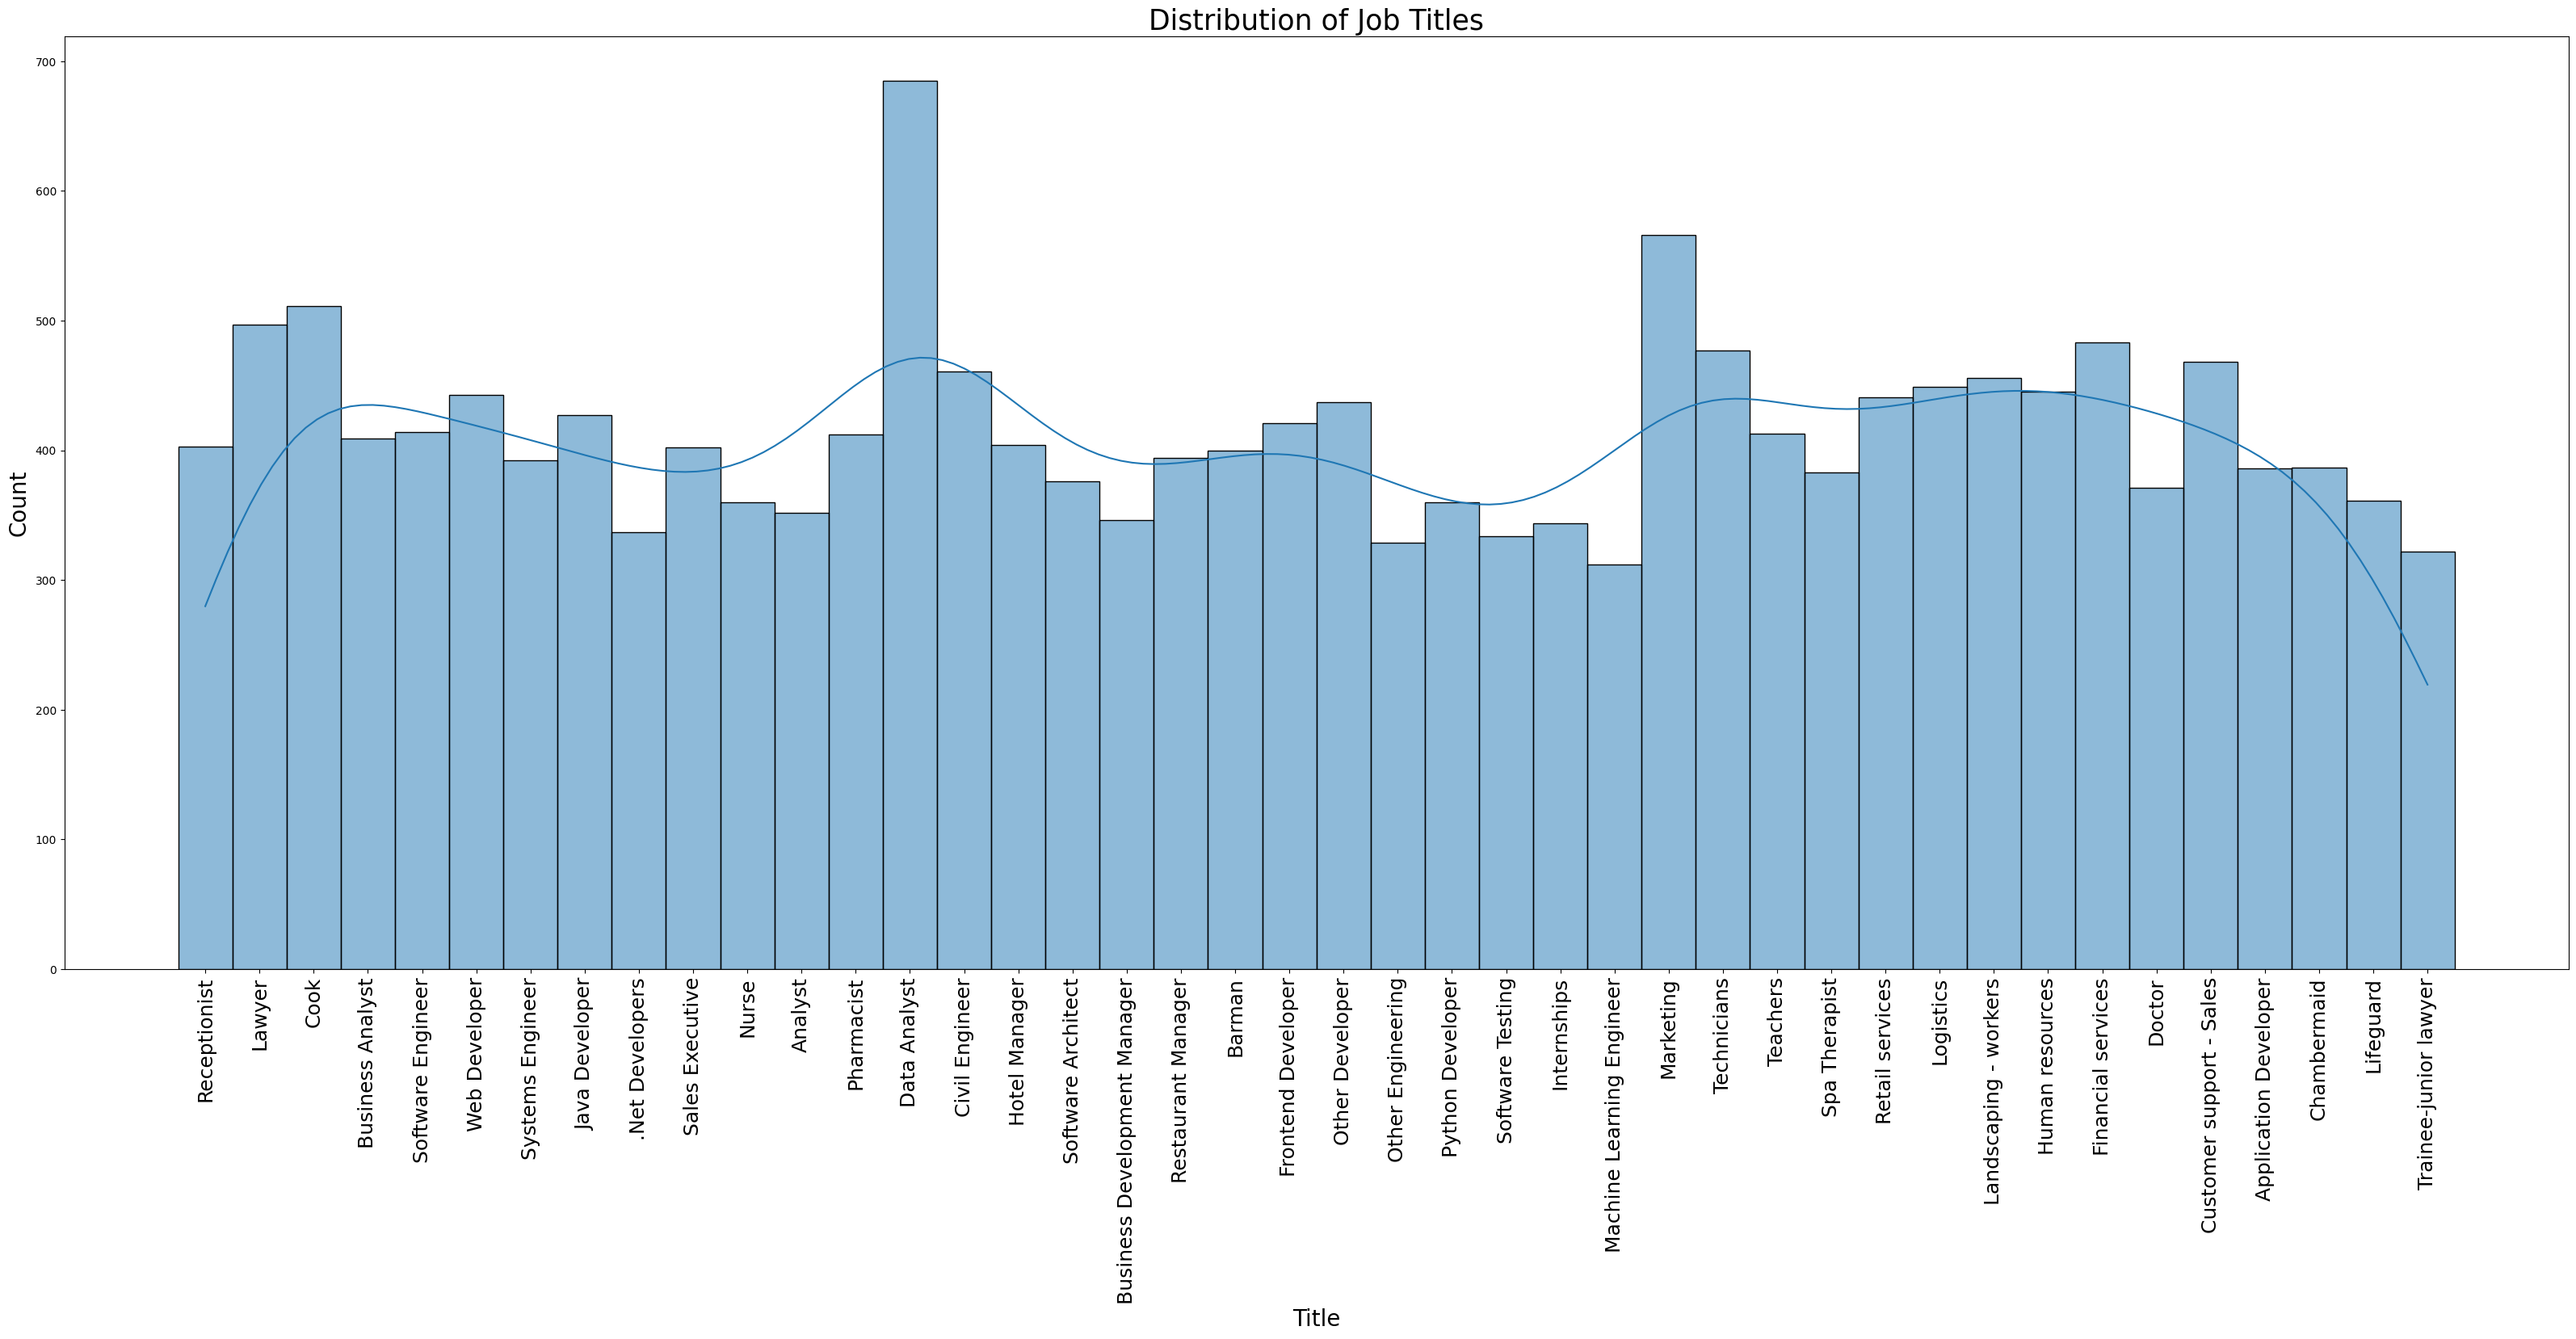

In [6]:
import seaborn as sns
plt.figure(figsize=(40, 15))
sns.histplot(x=df['Title'], kde=True)

# Set larger font size for x-axis labels
plt.xticks(rotation=90, fontsize=18)

# Set larger font size for x and y axis labels
plt.xlabel('Title', fontsize=20)
plt.ylabel('Count', fontsize=20)

# Set larger font size for title
plt.title('Distribution of Job Titles', fontsize=25)

plt.show()

In [7]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Label encoding for the 'Title' column
label_encoder = LabelEncoder()
df['Title'] = label_encoder.fit_transform(df['Title'])

# Split the dataset into training, validation, and testing sets (80%, 10%, 10%)
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
test_size = len(df) - train_size - val_size

train_texts, val_texts, test_texts = np.split(df.sample(frac=1, random_state=42), [train_size, train_size + val_size])

# Tokenize the texts
def tokenize_function(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")

train_encodings = tokenize_function(train_texts['Description'])
val_encodings = tokenize_function(val_texts['Description'])
test_encodings = tokenize_function(test_texts['Description'])

C:\Users\AIMVLab\.conda\envs\GPU\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


#### Creating Custom Dataset Class

In [8]:
class JobMatchingDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

# Create the dataset objects
train_dataset = JobMatchingDataset(train_encodings, train_texts['Title'])
val_dataset = JobMatchingDataset(val_encodings, val_texts['Title'])
test_dataset = JobMatchingDataset(test_encodings, test_texts['Title'])


#### Defining the Job Matching Model

In [9]:
class JobMatchingModel(nn.Module):
    def __init__(self, bert_model):
        super(JobMatchingModel, self).__init__()
        self.bert = bert_model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, len(label_encoder.classes_))

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs[1]  # Use the pooled output (last_hidden_state)
        output = self.drop(pooled_output)
        return self.out(output)


#### Preparing DataLoader

In [10]:
batch_size = 16  # Adjusted for hardware constraints # Learning Rate=3e-05, Batch Size=32, Epochs=3

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


#### Model Training Setup

In [11]:
num_epochs = 4  # Define the number of epochs

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = JobMatchingModel(bert_model=BertModel.from_pretrained('bert-base-uncased'))
model = model.to(device)

# Define optimizer with appropriate hyperparameters
optimizer = torch.optim.AdamW(params=model.parameters(), lr=5e-5,eps=1e-6, weight_decay=0.01)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Total training steps
total_steps = len(train_loader) * num_epochs

# Define the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


#### Training Loop with Time Measurement

In [12]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

start_time = time.time()  # Record the start time

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_examples = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update the learning rate
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_examples += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_examples

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss}, Training Accuracy: {accuracy}')
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_correct_predictions = 0
    val_total_examples = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_correct_predictions += (preds == labels).sum().item()
            val_total_examples += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct_predictions / val_total_examples

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}')

end_time = time.time()  # Record the end time
training_time = end_time - start_time  # Calculate the total training time

# Convert the training time to hh:mm:ss format
training_time_hms = time.strftime('%H:%M:%S', time.gmtime(training_time))

print(f'Total Training Time: {training_time_hms}')




C:\Users\AIMVLab\.conda\envs\GPU\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch 1/4, Training Loss: 1.20209963388218, Training Accuracy: 0.7214306275187105
Epoch 1/4, Validation Loss: 0.3883701744361208, Validation Accuracy: 0.9021301093839954
Epoch 2/4, Training Loss: 0.28697986533635983, Training Accuracy: 0.9271013241220495
Epoch 2/4, Validation Loss: 0.24497169544151343, Validation Accuracy: 0.9389752446747266
Epoch 3/4, Training Loss: 0.1314269624151058, Training Accuracy: 0.969559585492228
Epoch 3/4, Validation Loss: 0.22178369214536126, Validation Accuracy: 0.9510650546919976
Epoch 4/4, Training Loss: 0.06645046426915704, Training Accuracy: 0.9866148531951641
Epoch 4/4, Validation Loss: 0.20370387761434966, Validation Accuracy: 0.9585492227979274
Total Training Time: 00:21:10


In [13]:
# Save results to a DataFrame
results_df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Train Loss': train_losses,
    'Train Accuracy': train_accuracies,
    'Validation Loss': val_losses,
    'Validation Accuracy': val_accuracies
})

results_df.head()

,Epoch,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy
0,1,1.202100,0.721431,0.388370,0.902130
1,2,0.286980,0.927101,0.244972,0.938975
2,3,0.131427,0.969560,0.221784,0.951065
3,4,0.066450,0.986615,0.203704,0.958549


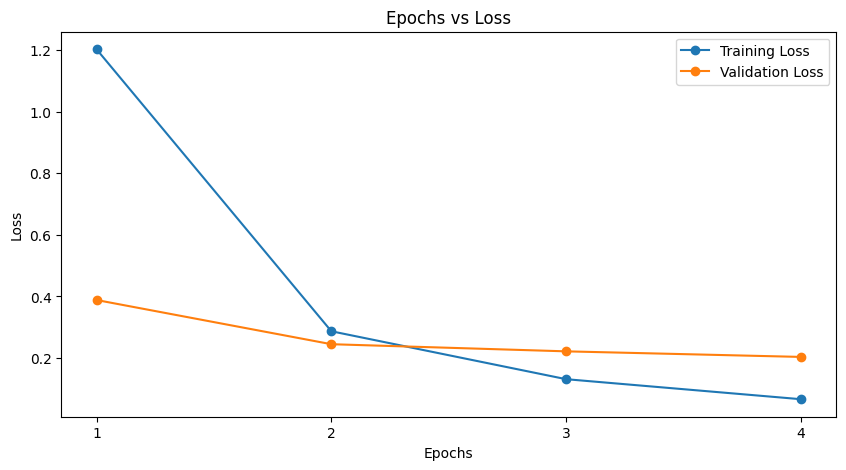

In [14]:
# Plotting Accuracy and Loss Over Epochs
import matplotlib.pyplot as plt
# Plot Loss over Epochs
plt.figure(figsize=(10, 5))
plt.plot(results_df['Epoch'], results_df['Train Loss'], marker='o', label='Training Loss')
plt.plot(results_df['Epoch'], results_df['Validation Loss'], marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.xticks([1,2,3,4])
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.show()


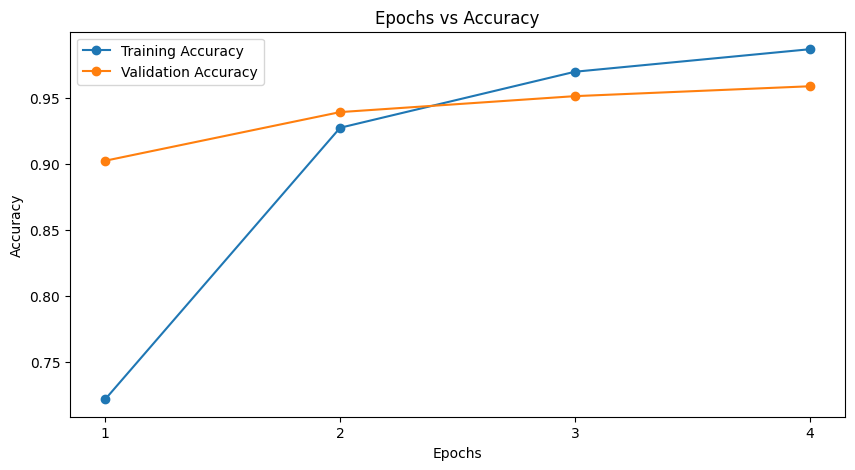

In [15]:
# Plot Accuracy over Epochs
plt.figure(figsize=(10, 5))
plt.plot(results_df['Epoch'], results_df['Train Accuracy'], marker='o', label='Training Accuracy')
plt.plot(results_df['Epoch'], results_df['Validation Accuracy'], marker='o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.xticks([1,2,3,4])
plt.ylabel('Accuracy')
plt.title('Epochs vs Accuracy')
plt.legend()
plt.show()

In [16]:
# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
predictions, true_labels = [], []

test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')


Accuracy: 0.953943580886586, Precision: 0.9544029267471311, Recall: 0.953943580886586, F1 Score: 0.9537536714351761


In [17]:
from sklearn.metrics import classification_report
import numpy as np

# Finding the number of unique classes in both true labels
unique_classes = np.unique(true_labels)

# Inversely transforming the unique classes to get their names
class_names = label_encoder.inverse_transform(unique_classes)

# Generating the classification report
print(classification_report(true_labels, predictions, labels=unique_classes, target_names=class_names))

                              precision    recall  f1-score   support

             .Net Developers       1.00      0.91      0.95        34
                     Analyst       0.81      0.83      0.82        35
       Application Developer       1.00      1.00      1.00        34
                      Barman       1.00      1.00      1.00        39
            Business Analyst       0.91      0.88      0.90        49
Business Development Manager       1.00      0.95      0.97        39
                 Chambermaid       1.00      1.00      1.00        36
              Civil Engineer       0.95      0.98      0.96        42
                        Cook       1.00      0.98      0.99        54
    Customer support - Sales       0.98      0.98      0.98        46
                Data Analyst       0.83      0.77      0.80        57
                      Doctor       0.97      1.00      0.98        32
          Financial services       0.98      0.96      0.97        55
          Frontend 

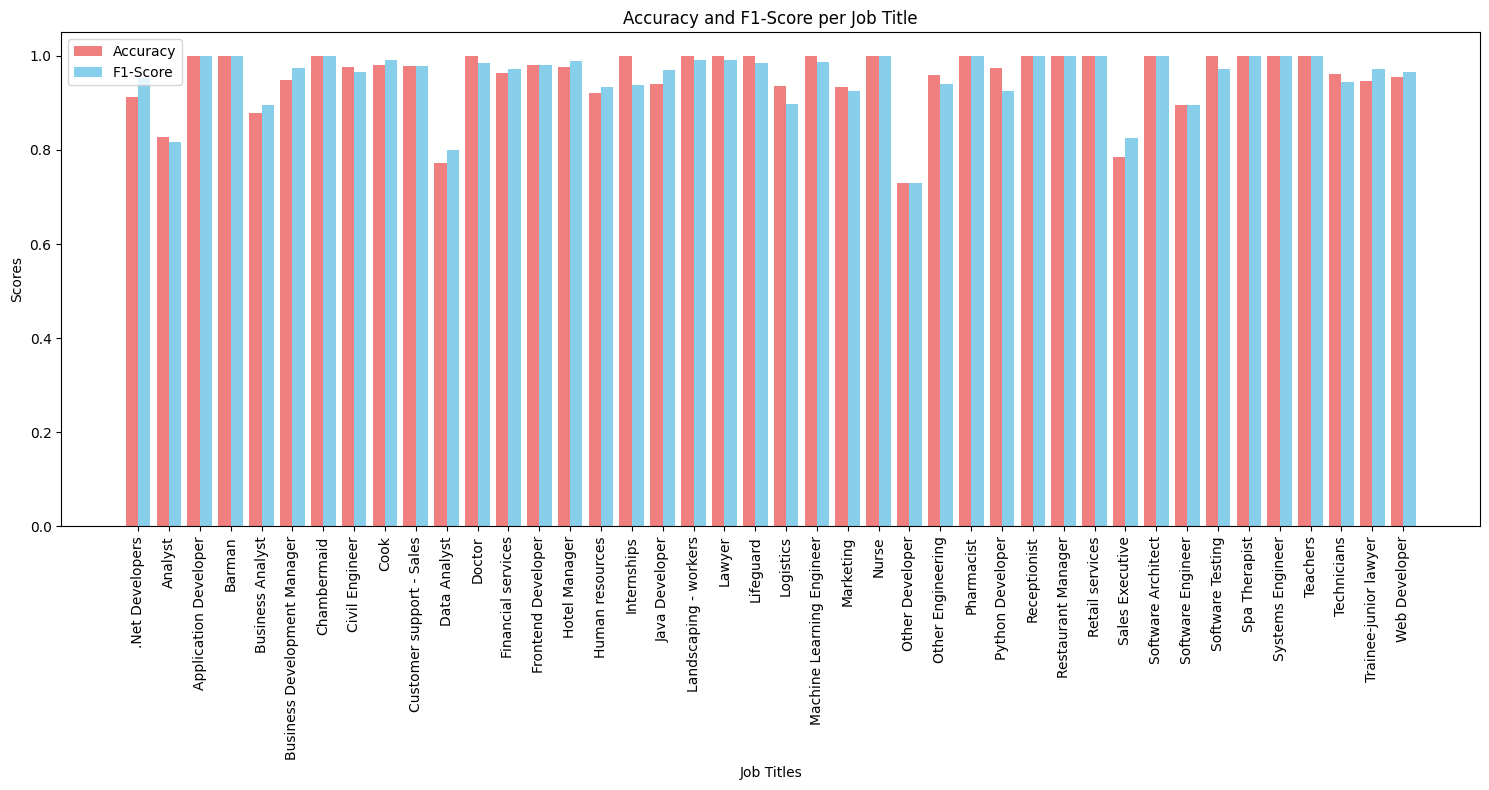

In [18]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np

# Convert true_labels and predictions to numpy arrays (if they aren't already)
true_labels_np = np.array(true_labels)
predictions_np = np.array(predictions)

# Get the classification report as a dictionary
report = classification_report(true_labels_np, predictions_np, labels=unique_classes, target_names=class_names, output_dict=True)

# Extract the F1-scores for each class
f1_scores = [report[title]['f1-score'] for title in label_encoder.classes_]

# Calculate the accuracy per class
accuracy_per_class = []
for i, title in enumerate(label_encoder.classes_):
    # Mask to filter only the samples that belong to class i
    class_mask = (true_labels_np == i)
    
    # Calculate accuracy for class i
    class_accuracy = accuracy_score(true_labels_np[class_mask], predictions_np[class_mask])
    accuracy_per_class.append(class_accuracy)

# Plotting the F1-scores and Accuracy for each class
plt.figure(figsize=(15, 8))
x = np.arange(len(label_encoder.classes_))

# Plot accuracy and F1-score with gentle colors
plt.bar(x - 0.2, accuracy_per_class, 0.4, label='Accuracy', color='#F08080')  # Peach
plt.bar(x + 0.2, f1_scores, 0.4, label='F1-Score', color='#87CEEB')  # Lavender

# Customize the plot
plt.xticks(x, label_encoder.classes_, rotation=90)
plt.xlabel('Job Titles')
plt.ylabel('Scores')
plt.title('Accuracy and F1-Score per Job Title')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


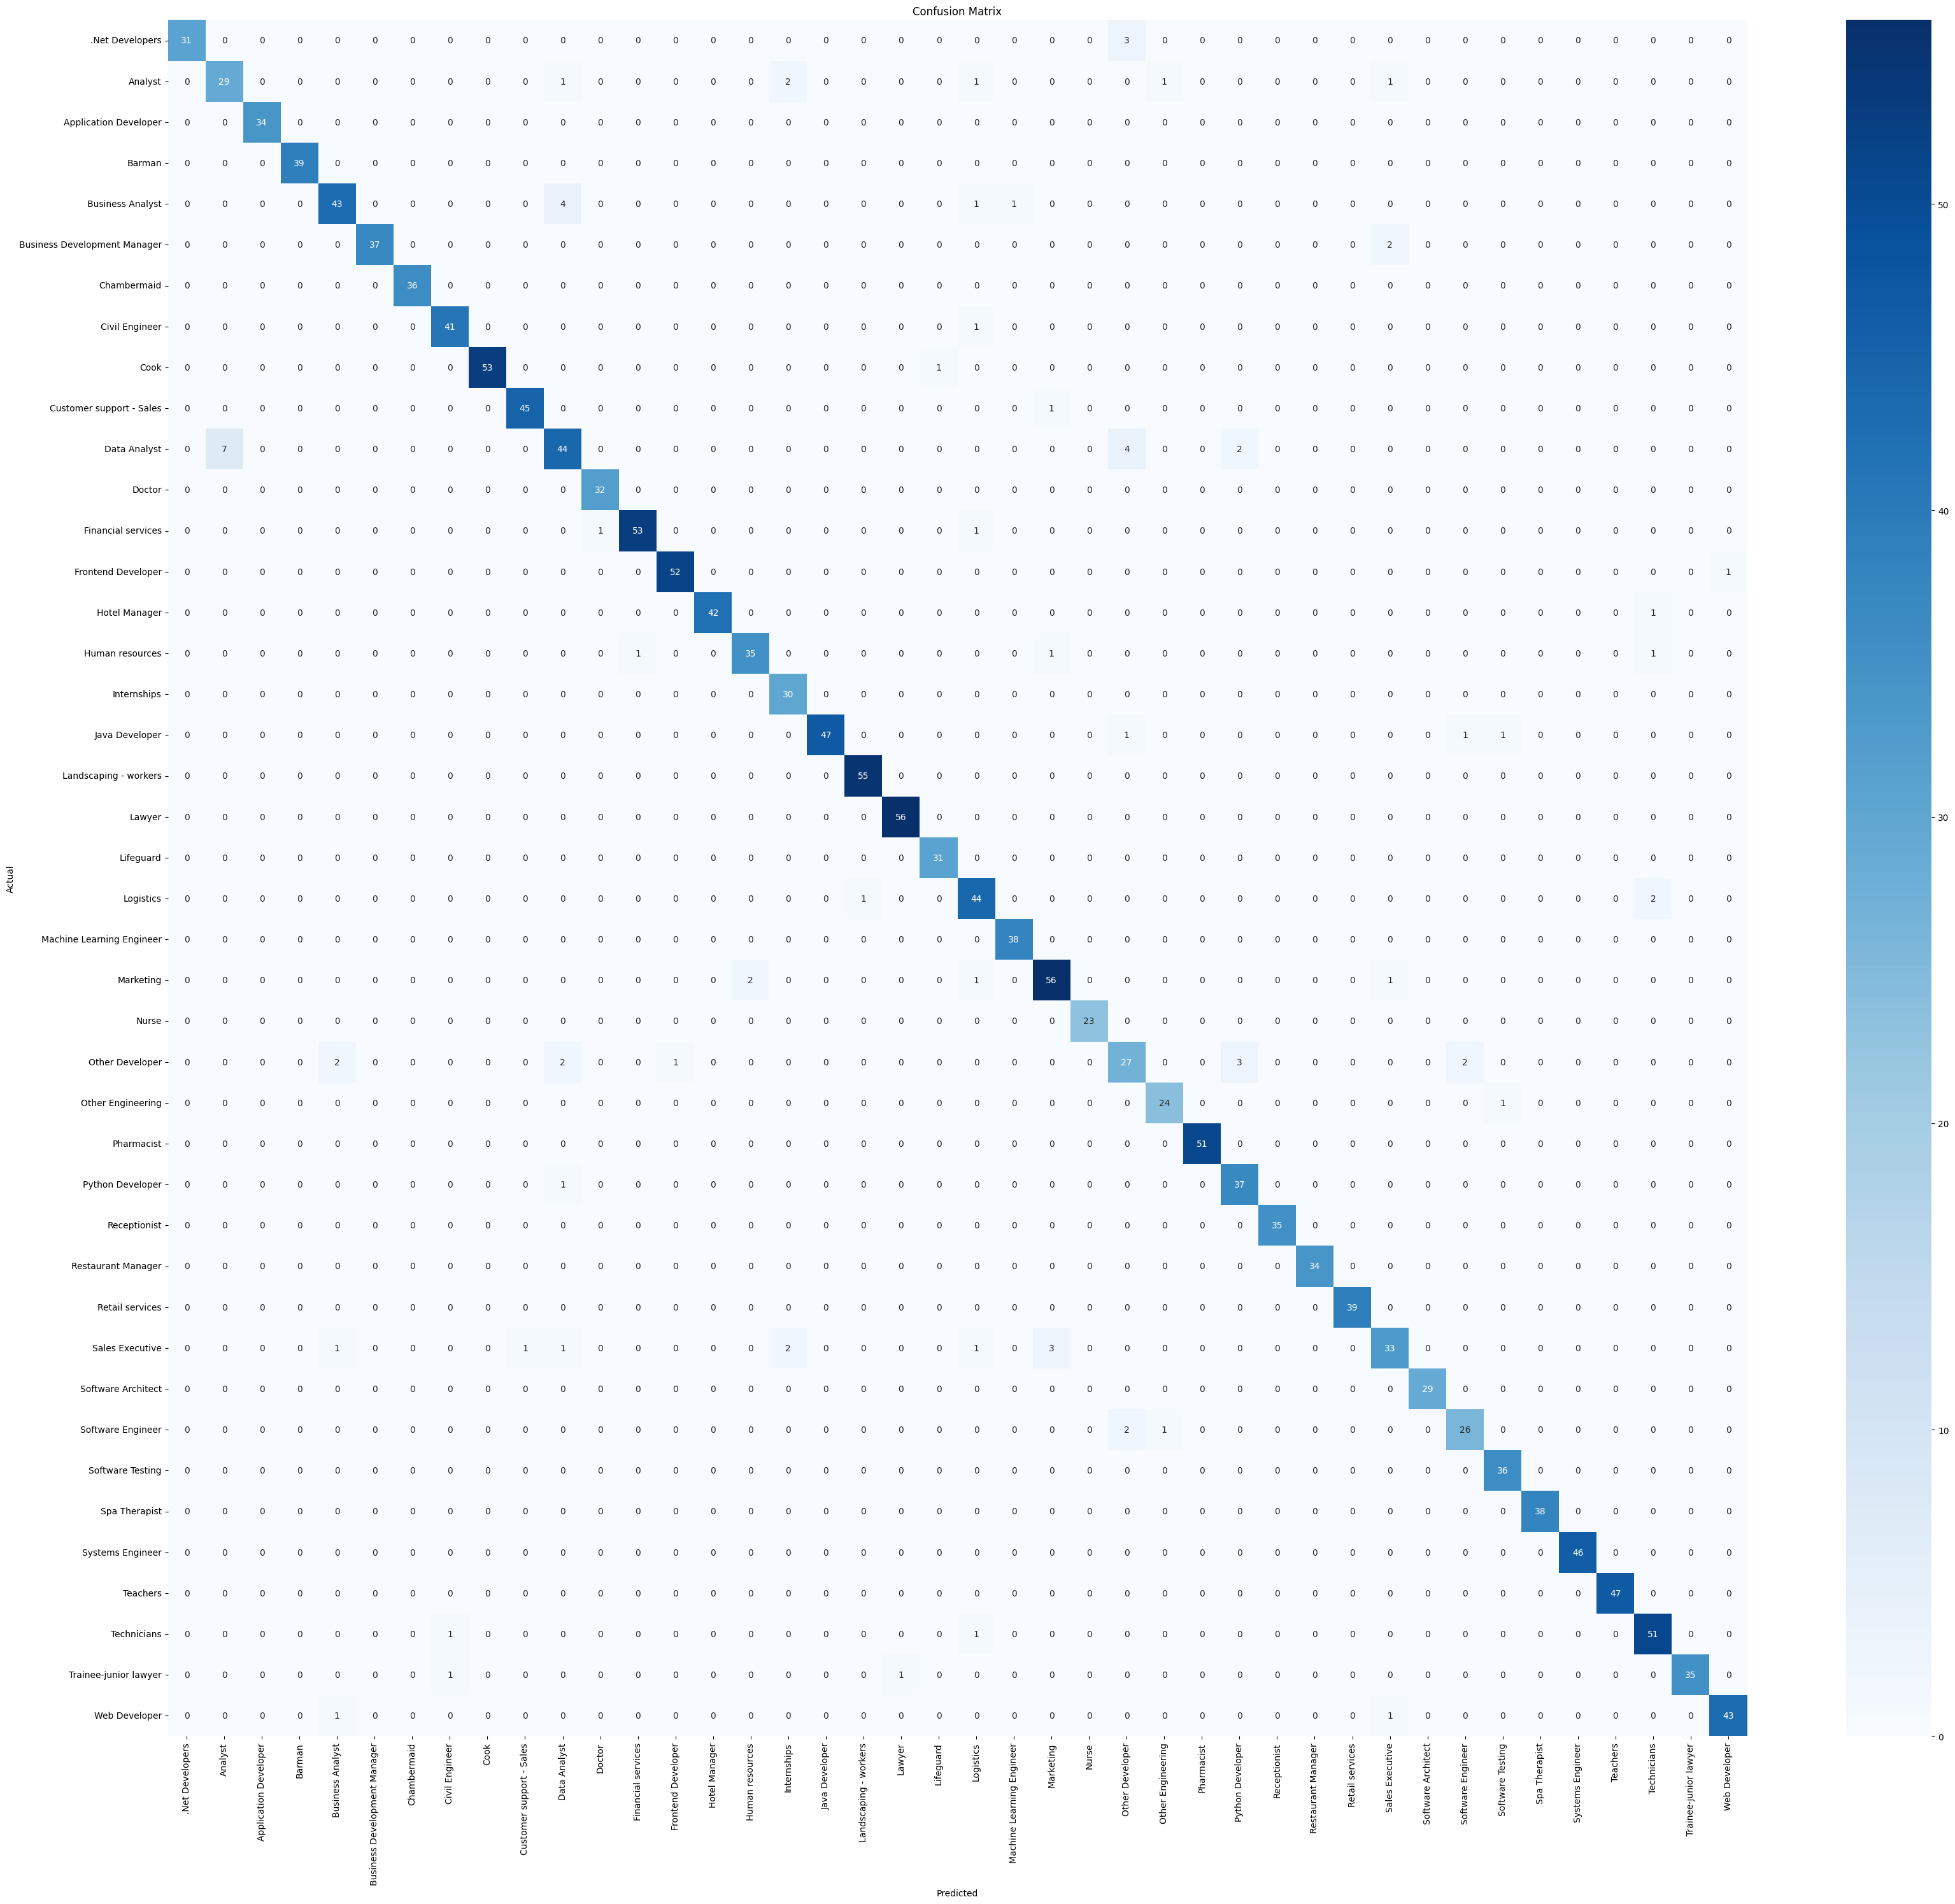

In [19]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(40,35))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


#### Saving the Model

In [20]:
# Assuming 'model' is your trained BERT model
model_save_path = 'bert_job_matching_model.pth'
torch.save(model.state_dict(), model_save_path)


In [21]:
# Define the model architecture first
bert_model = JobMatchingModel(bert_model=BertModel.from_pretrained('bert-base-uncased'))
bert_model.load_state_dict(torch.load('bert_job_matching_model.pth'))
bert_model.to(device)
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [22]:
import nltk  # Natural Language Toolkit, a comprehensive library for working with human language data.
import re # regular expressions, allowing for complex string searching and manipulation.
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, sent_tokenize, word_tokenize  # NLTK (Natural Language Toolkit) for natural language processing: pos_tag for part-of-speech tagging, sent_tokenize for sentence tokenization, word_tokenize for word tokenization.
from nltk.corpus import stopwords  # Provides a list of 'stopwords' that can be filtered out from text data.
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AIMVLab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:

def cleanResume(txt):
    # Ensure input is a string
    if isinstance(txt, str):
        # Remove URLs
        cleanText = re.sub('http\S+\s', ' ', txt)
        # Remove hashtags
        cleanText = re.sub('#\S+\s', ' ', cleanText)
        # Remove mentions
        cleanText = re.sub('@\S+', '  ', cleanText)
        # Remove punctuation
        cleanText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', cleanText)
        # Remove non-ASCII characters
        cleanText = re.sub(r'[^\x00-\x7f]', ' ', cleanText)
        # Normalize whitespace
        cleanText = re.sub('\s+', ' ', cleanText)

        sentences = sent_tokenize(cleanText) # Tokenize the text into sentences
        features = '' # Initialize the output text
        stop_words = set(stopwords.words("english")) # Define English stop words
        lemmatizer = WordNetLemmatizer() # Initialize the WordNet lemmatizer

        for sent in sentences:
            words = word_tokenize(sent) # Tokenize the sentence into words
            words = [word for word in words if word not in stop_words] # Filter out stop words
            tagged_words = pos_tag(words) # Tag words with their parts of speech
            filtered_words = [word for word, tag in tagged_words if tag not in ['DT', 'IN', 'TO', 'PRP', 'WP']] # Filter out certain POS tags
            lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words] # Lemmatize the filtered words
            features += " ".join(lemmatized_words) + " " # Add lemmatized words to features

        return features.strip() # Return the processed features, stripped of any extra spaces
    else:
        return txt  # Return the input as is if it's not a string


In [24]:
myresume='''The primary role of a Business Analyst is to bridge the gap between business stakeholders and technology teams, ensuring that the software and systems developed align with business requirements. The following is a comprehensive job description for a Business Analyst:

Job Title: Business Analyst

Job Summary: The Business Analyst will collaborate with various departments and stakeholders to gather, document, and analyze business requirements, processes, and workflows. They will translate these requirements into functional specifications for technology teams and work closely with project managers, developers, and testers to ensure successful project delivery. The Business Analyst will also be involved in identifying areas for process improvement and recommending solutions to enhance operational efficiency and effectiveness.

Responsibilities:

1. Requirement Elicitation and Analysis:

Work closely with business stakeholders to understand their needs, objectives, and challenges.
Elicit, document, and analyze business requirements, processes, and workflows.
Translate business requirements into clear and concise functional specifications for technical teams.
2. Solution Design:

Collaborate with technology teams to design solutions that meet business needs.
Propose innovative and practical solutions to address business challenges.
Ensure that proposed solutions align with the organization's strategic goals and technological capabilities.
3. Stakeholder Communication:

Serve as a liaison between business stakeholders and technology teams.
Communicate complex technical concepts to non-technical stakeholders.
Present findings, recommendations, and project updates to various audiences.
4. Documentation:

Create detailed documentation including business requirements, process flows, use cases, and user stories.
Maintain accurate and up-to-date project documentation throughout the project lifecycle.
5. Project Management:

Collaborate with project managers to define project scope, objectives, and deliverables.
Assist in project planning, estimation, and resource allocation.
Monitor project progress and identify potential risks or deviations from the plan.
6. Quality Assurance:

Participate in system testing, user acceptance testing, and validation of implemented solutions.
Ensure that delivered solutions meet the specified requirements and are of high quality.
7. Process Improvement:

Identify areas for process optimization and efficiency enhancement.
Recommend process improvements and assist in their implementation.
Qualifications:

Bachelor's degree in Business Administration, Information Technology, or a related field (Master's degree is a plus).
Proven experience as a Business Analyst or in a related role.
Strong analytical, problem-solving, and critical-thinking skills.
Excellent communication and interpersonal abilities.
Proficiency in requirement gathering techniques, process modeling, and documentation.
Familiarity with project management methodologies and software development lifecycle.
Ability to collaborate effectively with cross-functional teams.
Knowledge of relevant tools such as Microsoft Visio, JIRA, Confluence, etc.
Certification in Business Analysis (e.g., CBAP, CCBA) is advantageous.
Business Analyst Roles and Responsibilities
While business analyst roles and responsibilities involve several aspects, the primary role of a business analyst is to make changes within an organization. The solution-oriented changes improve an organization's overall efficiency, including process optimization, cost reduction, and identifying fresh business opportunities. Some of the Business Analyst responsibilities include:
'''
cleaned_resume = cleanResume(myresume)




In [25]:
def predict_job_title(model, tokenizer, resume_text):
    # Preprocess and tokenize the resume text
    inputs = tokenizer(
        resume_text,
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    # Move inputs to the device
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Set the model to evaluation mode
    model.eval()

    # Make predictions
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1)

    # Convert predicted label to job title
    predicted_label = preds.cpu().numpy()[0]
    job_title = label_encoder.inverse_transform([predicted_label])

    return job_title[0]

job_title = predict_job_title(model, tokenizer, cleaned_resume)
print(f'Predicted Job Title: {job_title}')

Predicted Job Title: Business Analyst
